# Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 



## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [156]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def fit(self, X, y):
        self.result = pd.Series(y).value_counts().argmax() # Replace with your code
        self.result_prob = pd.Series(y).value_counts(normalize=True)
        return None
        
    def predict(self, X):
        
        return np.full(X.shape[0],self.result)  # Replace with your code

    def predict_proba(self, X):
        
        return np.full((X.shape[0],2),self.result_prob)  # Replace with your code

    def score(self, X, y):
        
        return ((self.predict(X) == y).sum())/X.shape[0]  # Replace with your code

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [161]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))


Below are some tests for `predict_proba`.

In [162]:

assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [163]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [ ]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [38]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [39]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [40]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [41]:
# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# Initializing the Count Vectorizer
countvec = CountVectorizer(stop_words="english")

# Initializing the Logistic Regression
lr = LogisticRegression(max_iter=1000)

# Defining the Pipeline
pipe = make_pipeline(countvec, lr)

# Calculating the Cross Validation Results
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# Taking Mean
cross_val_results.mean()

fit_time       3.004422
score_time     0.214495
test_score     0.897890
train_score    0.967045
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:5}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [42]:
cross_val_results

,fit_time,score_time,test_score,train_score
0,1.624242,0.109707,0.899123,0.966014
1,3.321223,0.254983,0.899739,0.968859
2,3.457950,0.253815,0.896356,0.965976
3,3.296396,0.224896,0.898201,0.968552
4,3.322297,0.229072,0.896032,0.965823


**Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.**
- Yes, the Scores are extremely close to Each other as seen Above

**How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?**
- Here, the Number of rows (43,352) are signigicantly higher than that of the cities dataset (209); so here we are getting more accuracy in cross-validation because we have much higher records of the Data.

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [43]:
dr = DummyClassifier()

dr.fit(X_train,y_train)

# Calculating the Cross Validation Results
cross_val_results1 = pd.DataFrame(
    cross_validate(dr, X_train, y_train, return_train_score=True)
)

# Taking Mean
cross_val_results1.mean()

fit_time       0.005921
score_time     0.002393
test_score     0.738543
train_score    0.738543
dtype: float64

**Compare the DummyClassifier score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?**
- As we can see above, the score of DummyClassifier is significantly lower as compared to the logistic regression. So Logistic Regression should be used for this Dataset.

**Is it necessary to use CountVectorizer here? Briefly explain.**
- Yes here it is necessary to use countvectorizer because we have to convert string to float for the input in the model Logistic Regression.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [44]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [45]:
pred_prob = pd.DataFrame(pipe.predict_proba(X_test))
pred_prob.columns = ["Not Viral","Viral"]
pred_prob
pred_prob["Viral"].idxmax() # It gives 5134 Index where probability is max
print("The Highest Predicted Probability is:",pred_prob["Viral"].iloc[5134],"|| And the Associated Tweet:",X_test.iloc[5134])

The Highest Predicted Probability is: 0.9999999325326173 || And the Associated Tweet: Corrupt politician Adam Schiff wants people from the White House to testify in his and Pelosi’s disgraceful Witch Hunt, yet he will not allow a White House lawyer, nor will he allow ANY of our requested witnesses. This is a first in due process and Congressional history!


<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [46]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [47]:
 feature_names = np.array(vec_from_pipe.get_feature_names_out())
coeffs = lr_from_pipe.coef_.flatten()
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df
sorted_df = word_coeff_df.sort_values(by="Coefficient", ascending=False)
pd.concat([sorted_df.iloc[0:5],sorted_df.iloc[-5:]])

,Coefficient
harassment,2.731879
mini,2.712434
fake,2.692801
coronavirus,2.434266
transcripts,2.380514
1pic,-2.295069
trump2016,-2.316175
barackobama,-2.565429
trump2016pic,-2.637212
realdonaldtrump,-3.116927


<br><br>

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [60]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

In [69]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_train,y_train,test_size=0.2,random_state=1234)

In [70]:
X_train_f = countvec.fit_transform(X_train_f)
X_test_f = countvec.transform(X_test_f)

In [72]:
countvec.get_feature_names_out()

array(['00', '000', '0002', ..., 'सपन', 'सम', 'ｒｔ'], dtype=object)

In [73]:
lr.fit(X_train_f,y_train_f)

LogisticRegression(max_iter=1000)

In [75]:
lr.score(X_test_f,y_test_f)

0.8972781793018607

**This above is the Score Manually computed Validation Score!!**

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

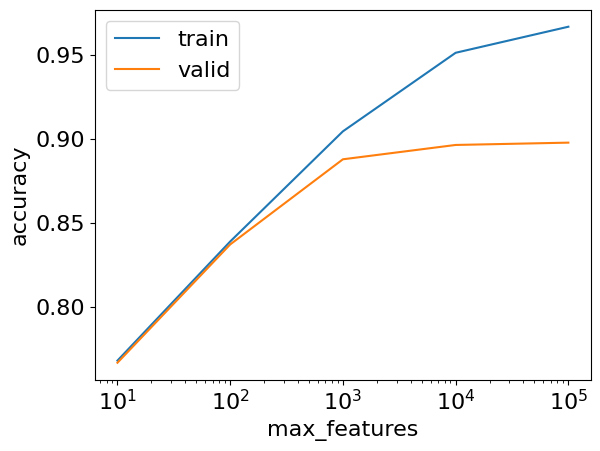

In [77]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [78]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.767854,0.766593
1,100,0.838900,0.837147
2,1000,0.904626,0.887956
3,10000,0.951498,0.896506
4,100000,0.967045,0.897890


<br><br>

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

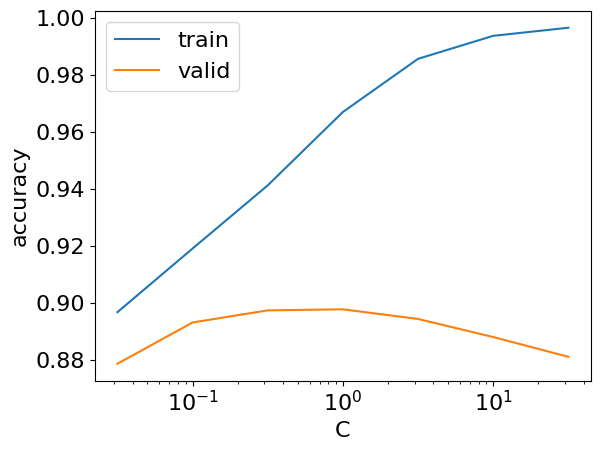

In [79]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [81]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.896898,0.878821
1,0.100000,0.919196,0.893277
2,0.316228,0.941333,0.897521
3,1.000000,0.967045,0.897890
4,3.162278,0.985683,0.894507
5,10.000000,0.993733,0.888171
6,31.622777,0.996578,0.881251


<br><br>

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [120]:
max_features = [10, 100, 1000, 10000, 100000]

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

pipe_lr = make_pipeline(
        CountVectorizer(stop_words="english"),
        LogisticRegression(max_iter=1000),
    )

param_grid = {
    "countvectorizer__max_features": max_features,
    "logisticregression__C": C_vals
}

gridsearch = GridSearchCV(pipe,param_grid,n_jobs=-1,cv=5,return_train_score=True)

In [121]:
gridsearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(C=31.622776601683793,
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ])},
             return_train_score=True)

In [123]:
gridsearch.best_params_


{'countvectorizer__max_features': 100000, 'logisticregression__C': 1.0}

**What are the best values of max_features and C according to your grid search?**
- The most Satisfying Values of max_features and C according to above code is C = 1.0, Max_Features = 100000

**Do these best values agree with what you found in parts (a) and (b)?**
- Yes, both the values are matching with that founded in the parts (A) and (B)

**Generally speaking, should these values agree with what you found in parts (a) and (b)? Explain.**
- Yes, Of Course they would agree because both have the same Implementation but GridSearch is somewhat already implemnted we just have to fit.

<br><br>

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [127]:
pipe_lr = make_pipeline(
        CountVectorizer(stop_words="english",max_features=100000),
        LogisticRegression(max_iter=1000,C=1),
    )

pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)

0.8992434028418528

<br><br><br><br>

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

**1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`?**
- If we fit and transform `CountVectorizer` on the Test Data, then we will be breaking the Golden Rule of Machine learning which is not to expose our test data during the training.

**2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?**
- Yes, it will be considered as leaking of the data and that model will be highly inaccurate to other unknown data.

**3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.**
- I would prefer to go with the `predict_proba`, because we can see the probability how confident the model is and quite helpful for us.

**4. What are two advantages of using sklearn `Pipeline`s?**
- The main two Advantages of using sklearn `Pipeline`:
    - We can combine multiple processes and can interpret them as steps, also work with them conveniently.
    - We can also fit, predict, and score directly using the Object of the Pipeline.

**5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?**
- The main two Advantages of `RandomizedSearchCV` over `GridSearchCV`:
    - Faster than GridSearchCV (Because it selects randomly from the params Grid)
    - Avoids unnecessary Computation

<br><br><br><br>